In [ ]:
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore')
plt.rc('font', size=12)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)
plt.rc('figure', titlesize=12)

----------
# Inspecting the data

## Reading the data

In [ ]:
df = pd.read_csv("/content/GBPUSD60.csv")

## Exploring the data

In [ ]:
cols = ['index', 'time', 'open', 'high', 'low', 'close', 'volume']

In [ ]:
df.columns = cols

In [ ]:
df.head()

,index,time,open,high,low,close,volume
0,1993.05.12,22:00,1.5328,1.5360,1.5180,1.5225,2571.0
1,1993.05.13,22:00,1.5228,1.5415,1.5200,1.5387,2711.0
2,1993.05.16,22:00,1.5365,1.5460,1.5309,1.5355,2921.0
3,1993.05.17,22:00,1.5350,1.5380,1.5237,1.5365,2711.0
4,1993.05.18,22:00,1.5350,1.5482,1.5328,1.5432,2261.0


## Convert data to timeseries form

In [ ]:
df['index'] = pd.to_datetime(df['index'])
df.drop(['open','close','volume','time'],axis=1,inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115677 entries, 0 to 115676
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   index   115677 non-null  datetime64[ns]
 1   high    115676 non-null  float64       
 2   low     115676 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 2.6 MB


In [ ]:
df['low'] = df['low'].astype('float64')
df['high'] = df['high'].astype('float64')

In [ ]:
df.set_index("index",inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 115677 entries, 1993-05-12 to 2017-06-07
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   high    115676 non-null  float64
 1   low     115676 non-null  float64
dtypes: float64(2)
memory usage: 2.6 MB


 ------------

 # EDA

In [ ]:
plt.style.use('ggplot')

## Overview monthly

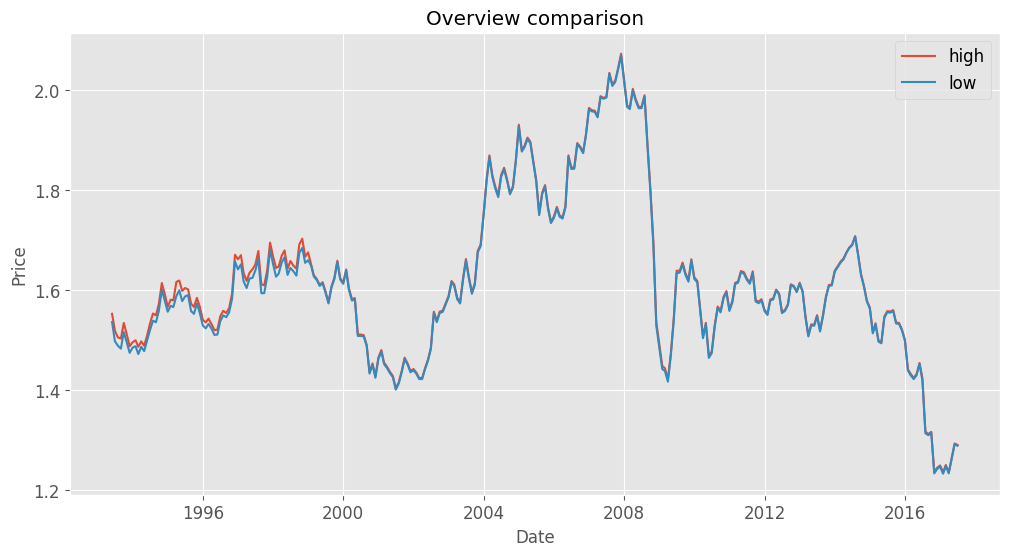

In [ ]:
plt.figure(figsize=(12,6))
plt.title("Overview comparison")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(df.resample("m").mean())
plt.legend(df.columns)
plt.show()

## Yearly Comparison

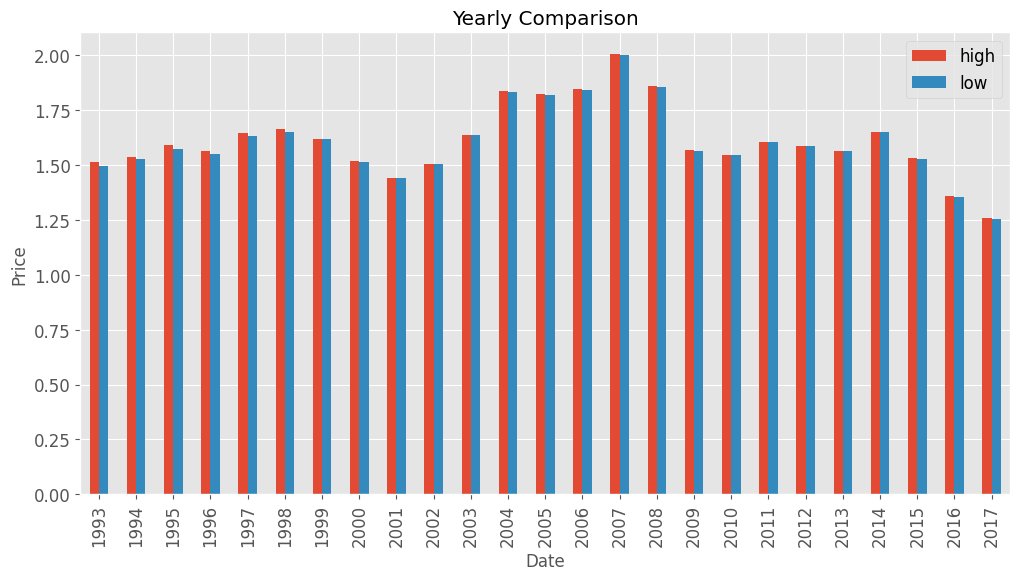

In [ ]:
df_year = df.copy()
df_year['year'] = df.index.year
df_year = df_year.reset_index().drop('index',axis=1).groupby('year').mean()
df_year.plot(kind='bar',figsize=(12,6),xlabel='Date',ylabel='Price',title='Yearly Comparison')
plt.show()

------------
# Preprocessing

## Scaling

In [ ]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
scalar_high = MinMaxScaler()
scalar_low = MinMaxScaler()
# df['high'] = scalar_high.fit_transform(df['high'].values.reshape(-1,1))
# df['low'] = scalar_low.fit_transform(df['low'].values.reshape(-1,1))

## Adjusting Data shape

In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back+1):
        a = dataset.iloc[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back-1])
    return np.array(dataX), np.array(dataY)

## Train-val-test split

In [ ]:
time_stamps = 15
train_size = round(len(df) * 0.7)
valid_size = round((len(df)-train_size)*0.7)
test_size = len(df) - (train_size+valid_size)
X_train, y_train = create_dataset(df[:train_size],time_stamps)
X_val, y_val = create_dataset(df[train_size:train_size+valid_size],time_stamps)
X_test, y_test = create_dataset(df[train_size+valid_size:],time_stamps)

In [ ]:
X_train = X_train.astype(np.float64)
y_train = y_train.astype(np.float64)
X_val = X_val.astype(np.float64)
y_val = y_val.astype(np.float64)
X_test = X_test.astype(np.float64)
y_test = y_test.astype(np.float64)

In [ ]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val", y_val.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (80960, 15, 2)
y_train:  (80960, 2)
X_val:  (24278, 15, 2)
y_val (24278, 2)
X_test:  (10397, 15, 2)
y_test (10397, 2)


# Modelling

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error
import tensorflow as tf
# The LSTM architecture
LSTM_model = Sequential()
# First LSTM layer with Dropout regularisation
LSTM_model.add(LSTM(units=32, return_sequences=True,activation='tanh', input_shape=(X_train.shape[1],X_train.shape[2])))
LSTM_model.add(Dropout(0.2))

LSTM_model.add(LSTM(units=64, return_sequences=True,activation='tanh'))
# LSTM_model.add(Dropout(0.2))

LSTM_model.add(LSTM(units=128, return_sequences=True,activation='tanh'))
LSTM_model.add(Dropout(0.2))

LSTM_model.add(LSTM(units=32,activation='tanh'))
# LSTM_model.add(Dropout(0.2))

LSTM_model.add(Dense(units=2))

LSTM_model.compile(optimizer='adam',loss='mean_absolute_error')

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True,
)

history = LSTM_model.fit(
    X_train,
    y_train,
    validation_data = (X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/100
1474/1474 [==============================] - 87s 55ms/step - loss: 0.0418 - val_loss: 0.0191
Epoch 2/100
1474/1474 [==============================] - 77s 52ms/step - loss: 0.0118 - val_loss: 0.0058
Epoch 3/100
1474/1474 [==============================] - 77s 52ms/step - loss: 0.0096 - val_loss: 0.0041
Epoch 4/100
1474/1474 [==============================] - 77s 52ms/step - loss: 0.0088 - val_loss: 0.0122
Epoch 5/100
1474/1474 [==============================] - 76s 51ms/step - loss: 0.0082 - val_loss: 0.0052
Epoch 6/100
1474/1474 [==============================] - 76s 52ms/step - loss: 0.0078 - val_loss: 0.0063
Epoch 7/100
1474/1474 [==============================] - 75s 51ms/step - loss: 0.0073 - val_loss: 0.0112
Epoch 8/100
1474/1474 [==============================] - 77s 52ms/step - loss: 0.0069 - val_loss: 0.0116
Epoch 9/100
1474/1474 [==============================] - 75s 51ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 10/100
1474/1474 [==============================]

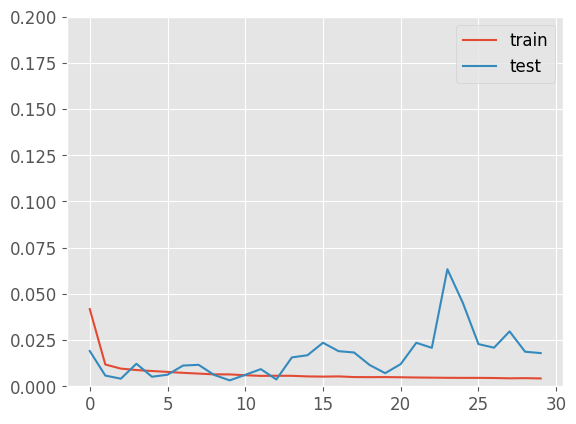

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.ylim(0,0.2)
plt.show()

# Evaluation

## High Predict

### Train Eveluation

In [ ]:
yhat = LSTM_model.predict(X_train)
yhat_inverse = yhat.copy()
# yhat_inverse[:,0] = scalar_high.inverse_transform(yhat[:,0].reshape(-1, 1)).reshape(-1,)
# yhat_inverse[:,1] = scalar_low.inverse_transform(yhat[:,1].reshape(-1, 1)).reshape(-1,)

y_test_inverse = y_train.copy()
# y_test_inverse[:,0] = scalar_high.inverse_transform(y_train[:,0].reshape(-1, 1)).reshape(-1,)
# y_test_inverse[:,1] = scalar_low.inverse_transform(y_train[:,1].reshape(-1, 1)).reshape(-1,)

dates = df.head(len(X_train)).index

2948/2948 [==============================] - 29s 10ms/step


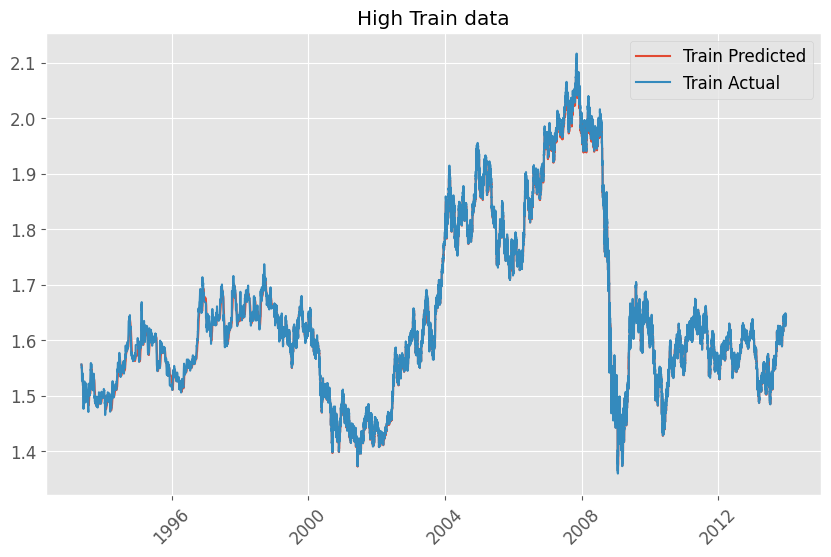

In [ ]:
plt.figure(figsize=(10,6))
plt.xticks(rotation=45)
plt.title("High Train data")
plt.plot(dates, yhat_inverse[:,0], label='Train Predicted')
plt.plot(dates, y_test_inverse[:,0], label='Train Actual')
plt.legend()
plt.show()

### Test Evaluation

In [ ]:
yhat = LSTM_model.predict(X_test)
yhat_inverse = yhat.copy()
# yhat_inverse[:,0] = scalar_high.inverse_transform(yhat[:,0].reshape(-1, 1)).reshape(-1,)
# yhat_inverse[:,1] = scalar_low.inverse_transform(yhat[:,1].reshape(-1, 1)).reshape(-1,)

y_test_inverse = y_test.copy()
# y_test_inverse[:,0] = scalar_high.inverse_transform(y_test[:,0].reshape(-1, 1)).reshape(-1,)
# y_test_inverse[:,1] = scalar_low.inverse_transform(y_test[:,1].reshape(-1, 1)).reshape(-1,)


379/379 [==============================] - 4s 11ms/step


In [ ]:
df_high_res = pd.DataFrame(
    {
        "High Actual":y_test_inverse[:,0],
        "High Forecast":yhat_inverse[:,0],
        "Diff":abs(y_test_inverse[:,0]-yhat_inverse[:,0]),
    }
)
df_high_res['date'] = df.tail(len(X_test)).index
df_high_res.set_index("date",inplace=True)

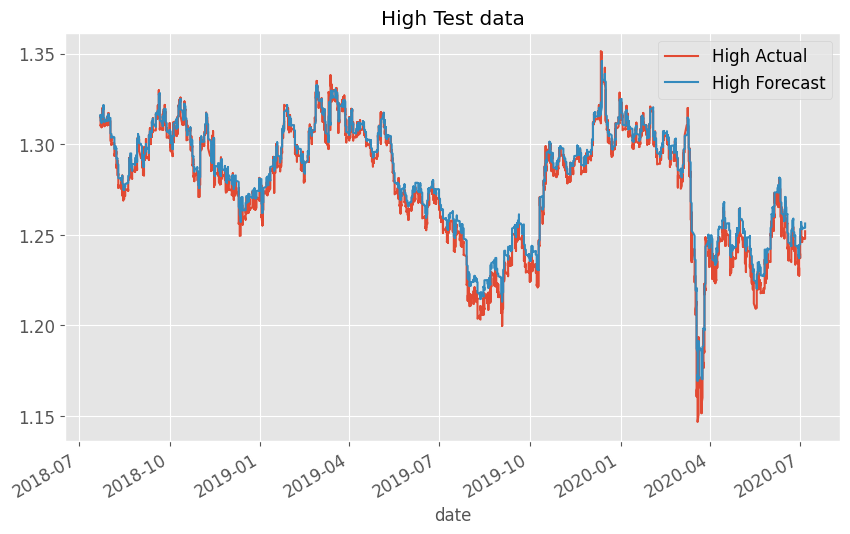

In [ ]:
df_high_res[['High Actual', 'High Forecast']].plot(figsize=(10,6),title="High Test data")
plt.show()

In [ ]:
from sklearn import metrics
mse = metrics.mean_squared_error(df_high_res["High Actual"], df_high_res["High Forecast"])
mae = metrics.mean_absolute_error(df_high_res["High Actual"], df_high_res["High Forecast"])
mape = metrics.mean_absolute_percentage_error(df_high_res["High Actual"], df_high_res["High Forecast"])
print("High evalutaion:")
print('MSE: %f' % mse)
print('MAE: %f' % mae)
print('MAPE: %f' % mape)

High evalutaion:
MSE: 0.000030
MAE: 0.004472
MAPE: 0.003555


## Low Predict

### Train Evaluation

In [ ]:
yhat = LSTM_model.predict(X_train)
yhat_inverse = yhat.copy()
# yhat_inverse[:,0] = scalar_high.inverse_transform(yhat[:,0].reshape(-1, 1)).reshape(-1,)
# yhat_inverse[:,1] = scalar_low.inverse_transform(yhat[:,1].reshape(-1, 1)).reshape(-1,)

y_test_inverse = y_train.copy()
# y_test_inverse[:,0] = scalar_high.inverse_transform(y_train[:,0].reshape(-1, 1)).reshape(-1,)
# y_test_inverse[:,1] = scalar_low.inverse_transform(y_train[:,1].reshape(-1, 1)).reshape(-1,)

dates = df.head(len(X_train)).index

2948/2948 [==============================] - 29s 10ms/step


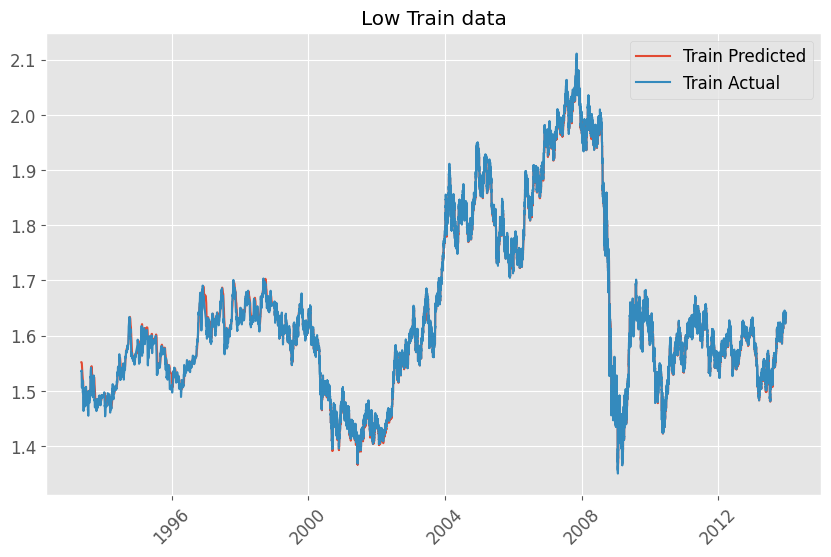

In [ ]:
plt.figure(figsize=(10,6))
plt.xticks(rotation=45)
plt.title("Low Train data")
plt.plot(dates, yhat_inverse[:,1], label='Train Predicted')
plt.plot(dates, y_test_inverse[:,1], label='Train Actual')
plt.legend()
plt.show()

### Test Evaluation

In [ ]:
yhat = LSTM_model.predict(X_test)
yhat_inverse = yhat.copy()
# yhat_inverse[:,0] = scalar_high.inverse_transform(yhat[:,0].reshape(-1, 1)).reshape(-1,)
# yhat_inverse[:,1] = scalar_low.inverse_transform(yhat[:,1].reshape(-1, 1)).reshape(-1,)

y_test_inverse = y_test.copy()
# y_test_inverse[:,0] = scalar_high.inverse_transform(y_test[:,0].reshape(-1, 1)).reshape(-1,)
# y_test_inverse[:,1] = scalar_low.inverse_transform(y_test[:,1].reshape(-1, 1)).reshape(-1,)


379/379 [==============================] - 3s 9ms/step


In [ ]:
df_low_res = pd.DataFrame(
    {
        "Low Actual":y_test_inverse[:,1],
        "Low Forecast":yhat_inverse[:,1],
        "Diff":abs(y_test_inverse[:,1]-yhat_inverse[:,1]),
    }
)
df_low_res['date'] = df.tail(len(X_test)).index
df_low_res.set_index("date",inplace=True)

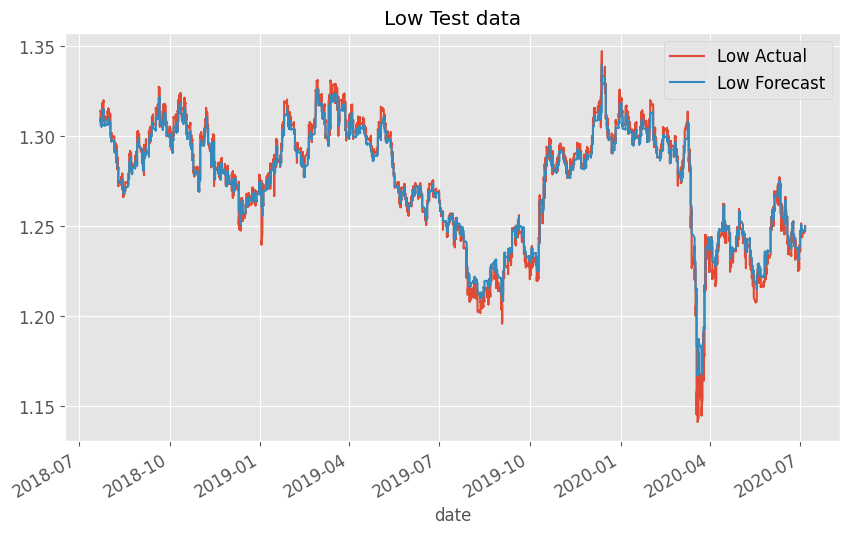

In [ ]:
df_low_res[['Low Actual', 'Low Forecast']].plot(figsize=(10,6),title="Low Test data")
plt.show()

In [ ]:
from sklearn import metrics
mse = metrics.mean_squared_error(df_low_res["Low Actual"], df_low_res["Low Forecast"])
mae = metrics.mean_absolute_error(df_low_res["Low Actual"], df_low_res["Low Forecast"])
mape = metrics.mean_absolute_percentage_error(df_low_res["Low Actual"], df_low_res["Low Forecast"])
score = metrics.r2_score(df_low_res["Low Actual"], df_low_res["Low Forecast"])
print("Low evalutaion:")
print('MSE: %f' % mse)
print('MAE: %f' % mae)
print('MAPE: %f' % mape)
print('score: %f' % score)

Low evalutaion:
MSE: 0.000019
MAE: 0.003243
MAPE: 0.002563
score: 0.983320


# Future Forecasting

In [ ]:
def predict_and_generate(data_item, model):
    # Predict new value
    predicted_value = model.predict(data_item, verbose=-1)
    # and the new value and remove the old one
    new_data_item = np.vstack([data_item[0][1:], predicted_value])
    # reshape the data item to the proper shape
    new_data_item = new_data_item.reshape(1, new_data_item.shape[0],-1)

    return predicted_value, new_data_item


In [ ]:
def predict_period(start, end):
    assert start <= end
    data_item, _ = create_dataset(df.iloc[-15:], time_stamps)
    last_date = df.iloc[-1].name
    # Move untill required date
    while last_date < pd.Timestamp(start):
        _, data_item = predict_and_generate(data_item, LSTM_model)
        last_date += pd.DateOffset(1)

    predicted = pd.DataFrame(columns = ['high','low'], index = pd.date_range(start=start, end = end))
    for date in predicted.index:
        predicted_item, data_item = predict_and_generate(data_item, LSTM_model)
        predicted.loc[date] = predicted_item

    return predicted

In [ ]:
# Specify the time period you want to predict
# *** Note: the period must be after the last date in the data ***
# *** Note: the farther the period you want to predict, the worse and inaccurate the results will be ***
predicted = predict_period(start="2023-05-20", end = "2023-05-27")
predicted

,high,low
2023-05-20,1.320133,1.31354
2023-05-21,1.320133,1.31354
2023-05-22,1.320133,1.31354
2023-05-23,1.320133,1.31354
2023-05-24,1.320133,1.31354
2023-05-25,1.320133,1.31354
2023-05-26,1.320133,1.31354
2023-05-27,1.320133,1.31354
